In [11]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import sys
sys.path.append('..')

from lib.WTTE import WTTE
from lib.ChurnEnsemble import ChurnEnsemble
from lib.utils import format_number, show_summary

SEED = 42
np.random.seed(SEED)

In [12]:
config = dict(
    features=[
        'plan', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
        'failed', 'usage', 'usage_groups', 'usage_payments', 'momentum'
    ],
    params={}
)

min_tte = 1  # Minimum time to event for binary classification (positive if `tte` <= `min_tte`)
max_sl = 24  # Maximum sequence length (0 = max length from data)
wlevel = 'epoch'  # Level to save the weights and bias (epoch or batch)
test_size = 0.25  # Percentage of the data to use for test/validation

In [13]:
data = pd.read_csv('../files/churn-data-fit.csv')

for col in ['tp', 'ts', 'te']:
    data[col] = pd.to_datetime(data[col])

cs = (data.sort_values(['id', 'tfs']).groupby('id')['tte'].last() < 0).value_counts().sort_index().astype(float)
print('Total Customers: {} | Censored: {} | Non-censored: {} | Censored Rate {}%'.format(
    format_number(cs.sum()),
    format_number(cs[1]),
    format_number(cs[0]),
    format_number(100 * cs[1] / cs.sum(), 2)
))

data

Total Customers: 11.069 | Censored: 2.678 | Non-censored: 8.391 | Censored Rate 24,19%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,momentum,months,failed_ratio,usage_diff
0,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,1.0,0.00,4.0,NaN,0.00
1,51b46d18c4de615d0f000019,1,2017-08-01,5.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,2.0,1.20,5.0,NaN,0.00
2,51b46d18c4de615d0f000019,1,2017-09-01,6.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,2.00,0.0,0.0,1.0,0.0,3.0,-3.14,6.0,0.0,0.00
3,51b46d18c4de615d0f000019,1,2017-10-01,7.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.75,0.0,0.0,1.0,0.0,3.0,-13.60,7.0,0.0,-0.75
4,51b46d18c4de615d0f000019,1,2017-11-01,8.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.60,0.0,0.0,1.0,0.0,3.0,-18.57,8.0,0.0,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201230,66633bcee489710bb6afe3d9,11065,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,101.97,101.97,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201231,666346aee489710bb6afead3,11066,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,40.00,40.00,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201232,66634aea1e0bd65a73bf4f2f,11067,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,46.62,46.62,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201233,666388b3e489710bb6b00925,11068,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,60.19,60.19,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00


In [14]:
d_split = data.sort_values(['id', 'tp']).groupby('id')['tte'].last().reset_index()
d_split['censored'] = d_split['tte'] < 0

d_train, d_test = train_test_split(
    d_split,
    test_size=test_size,
    shuffle=True,
    stratify=d_split['censored'].astype(int),
    random_state=SEED
)

cs_train = d_train['censored'].value_counts().sort_index().astype(float)
cs_test = d_test['censored'].value_counts().sort_index().astype(float)

print('Total Customers: {} ({}% censored) | Train: {} ({}%) | Test: {} ({}%)'.format(
    format_number(len(d_split)),
    format_number(100 * cs[1] / cs.sum(), 2),
    format_number(len(d_train)),
    format_number(100 * cs_train[1] / cs_train.sum(), 2),
    format_number(len(d_test)),
    format_number(100 * cs_test[1] / cs_test.sum(), 2)
))

Total Customers: 11.069 (24,19% censored) | Train: 8.301 (24,19%) | Test: 2.768 (24,21%)


In [15]:
# Clean previous data path
if os.path.exists('../files/wtte'):
    shutil.rmtree('../files/wtte')

# Instantiate the WTTE Time To Event model
wtte = WTTE(
    features=config['features'],
    min_tte=min_tte,
    max_sl=max_sl,
    wlevel=wlevel,
    seed=SEED,
    verbose=2,
    path='../files/wtte',
    **config['params']
)

wtte.params

{'nn': 0,
 'hl': 2,
 'lr': 0.0001,
 'epochs': 200,
 'batch': 512,
 'lr_decay': 0,
 'stop': 0,
 'dropout': 0.1,
 'weight_l1': 0,
 'weight_l2': 1e-05,
 'init_alpha': None,
 'max_beta': 2.0,
 'shuffle': False,
 'epsilon': 1e-08}

In [16]:
# Set train data
d_wtte_train = data[data['id'].isin(d_train['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + wtte.features
]

# Scale/Normalize features
wtte.scaler = StandardScaler().fit(d_wtte_train[wtte.features])
d_wtte_train[wtte.features] = wtte.scaler.transform(d_wtte_train[wtte.features])

# Build train tensor
x_wtte_train, y_wtte_train = wtte.build_seq(d_wtte_train, deep=False)
df_wtte_train = wtte.seq_to_df(x_wtte_train, y_wtte_train)

print(x_wtte_train.shape, y_wtte_train.shape)
df_wtte_train

(8301, 25, 14) (8301, 25, 5)


,id,seq,tfs,wa,wb,plan,interval,country_es,country_mx,country_latam,gateway_auto,failed,usage,usage_groups,usage_payments,momentum
0,1.0,63.0,0.0,24.0,0.0,-0.574489,0.171768,1.198058,-0.542737,-0.57828,0.183716,2.009340,-1.3876,-0.206605,-0.093025,-0.814738
1,1.0,63.0,1.0,23.0,0.0,-0.574489,0.171768,1.198058,-0.542737,-0.57828,0.183716,2.009340,-1.3876,-0.206605,-0.093025,-0.654770
2,1.0,63.0,2.0,22.0,0.0,-0.574489,0.171768,1.198058,-0.542737,-0.57828,0.183716,-0.497676,-1.3876,-0.206605,-0.093025,-0.441886
3,1.0,63.0,3.0,21.0,0.0,-0.574489,0.171768,1.198058,-0.542737,-0.57828,0.183716,-0.497676,-1.3876,-0.206605,-0.093025,0.714988
4,1.0,63.0,4.0,20.0,0.0,-0.574489,0.171768,1.198058,-0.542737,-0.57828,0.183716,-0.497676,-1.3876,-0.206605,-0.093025,-0.173044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207520,11069.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207521,11069.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207522,11069.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207523,11069.0,0.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Set test data
d_wtte_test = data[data['id'].isin(d_test['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + wtte.features
]

# Scale/Normalize features (using the scaler from the training data)
d_wtte_test[wtte.features] = wtte.scaler.transform(d_wtte_test[wtte.features])

# Build test tensor
x_wtte_test, y_wtte_test = wtte.build_seq(d_wtte_test, deep=False)
df_wtte_test = wtte.seq_to_df(x_wtte_test, y_wtte_test)

print(x_wtte_test.shape, y_wtte_test.shape)
df_wtte_test

(2768, 25, 14) (2768, 25, 5)


,id,seq,tfs,wa,wb,plan,interval,country_es,country_mx,country_latam,gateway_auto,failed,usage,usage_groups,usage_payments,momentum
0,9.0,4.0,0.0,4.0,1.0,-0.574489,-0.400906,1.198058,-0.542737,-0.57828,0.183716,-0.497676,-0.142468,-0.206605,-0.093025,-0.097014
1,9.0,4.0,1.0,3.0,1.0,-0.574489,-0.400906,1.198058,-0.542737,-0.57828,0.183716,2.009340,-0.142468,-0.206605,-0.093025,-0.073900
2,9.0,4.0,2.0,2.0,1.0,-0.574489,-0.400906,1.198058,-0.542737,-0.57828,0.183716,-0.497676,-0.142468,-0.206605,-0.093025,-0.077550
3,9.0,4.0,3.0,1.0,1.0,-0.574489,-0.400906,1.198058,-0.542737,-0.57828,0.183716,2.009340,-0.142468,-0.206605,-0.093025,-0.139590
4,9.0,4.0,4.0,0.0,1.0,-0.574489,-0.400906,1.198058,-0.542737,-0.57828,0.183716,2.009340,-0.765034,-0.206605,-0.093025,-0.507576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69195,11066.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69196,11066.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69197,11066.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69198,11066.0,0.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Fit WTTE model
wtte.fit(x_wtte_train, y_wtte_train, x_wtte_test, y_wtte_test)

discrete -> Max Length: 24 | Mask: -6.44
Alpha Mean: 8.75 | Beta Mean: 0.63
Init Alpha: 9.24 | Max Beta: 2.00


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 11)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 24)       │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 24)       │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 2)        │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, None, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,306 (32.45 KB)

 Trainable params: 8,306 (32.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
17/17 - 8s - 491ms/step - loss: 3.5936 - val_loss: 3.0800
Epoch 2/200
17/17 - 2s - 95ms/step - loss: 3.1859 - val_loss: 2.8485
Epoch 3/200
17/17 - 2s - 90ms/step - loss: 2.9285 - val_loss: 2.6746
Epoch 4/200
17/17 - 1s - 88ms/step - loss: 2.7835 - val_loss: 2.5388
Epoch 5/200
17/17 - 2s - 91ms/step - loss: 2.6518 - val_loss: 2.4464
Epoch 6/200
17/17 - 2s - 96ms/step - loss: 2.5622 - val_loss: 2.3803
Epoch 7/200
17/17 - 2s - 92ms/step - loss: 2.4762 - val_loss: 2.3315
Epoch 8/200
17/17 - 1s - 80ms/step - loss: 2.4276 - val_loss: 2.2953
Epoch 9/200
17/17 - 1s - 81ms/step - loss: 2.3748 - val_loss: 2.2702
Epoch 10/200
17/17 - 1s - 81ms/step - loss: 2.3362 - val_loss: 2.2464
Epoch 11/200
17/17 - 1s - 81ms/step - loss: 2.3110 - val_loss: 2.2273
Epoch 12/200
17/17 - 1s - 82ms/step - loss: 2.2904 - val_loss: 2.2117
Epoch 13/200
17/17 - 1s - 81ms/step - loss: 2.2753 - val_loss: 2.1979
Epoch 14/200
17/17 - 1s - 85ms/step - loss: 2.2581 - val_loss: 2.1847
Epoch 15/200
17/17 - 2s - 10

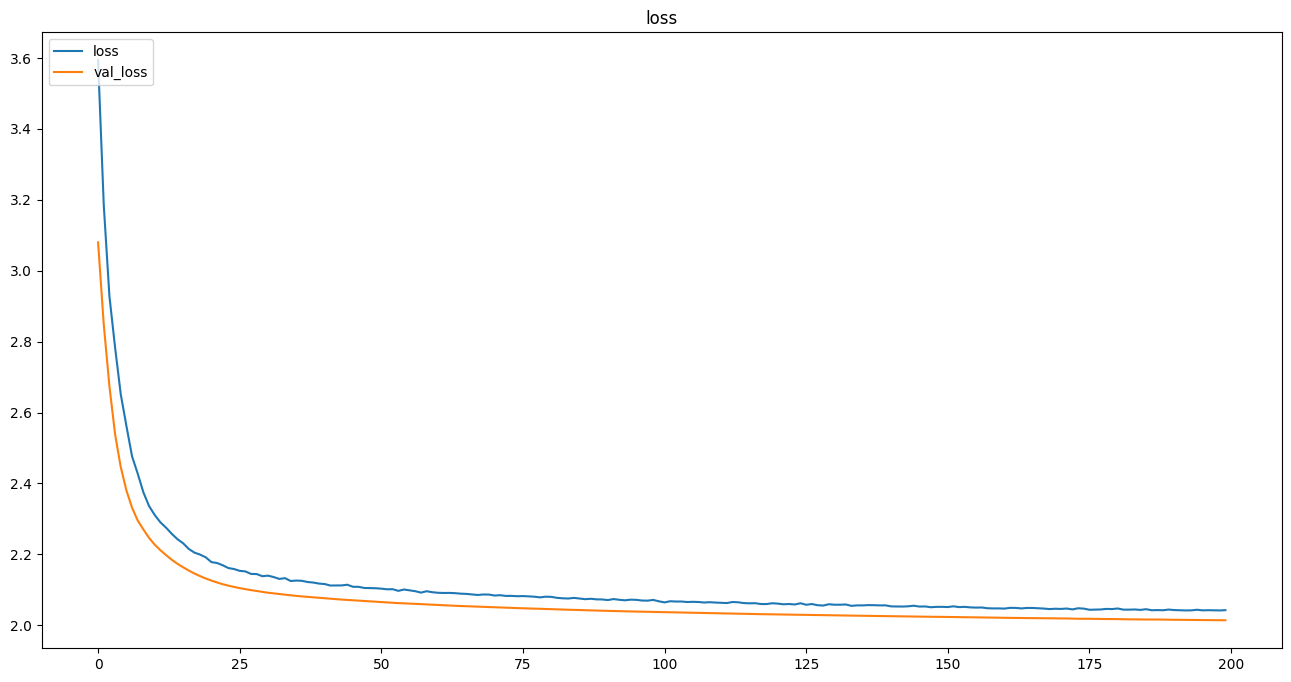

In [19]:
# Save model
wtte.save()

# Plot training history
wtte.plot_history_eval()

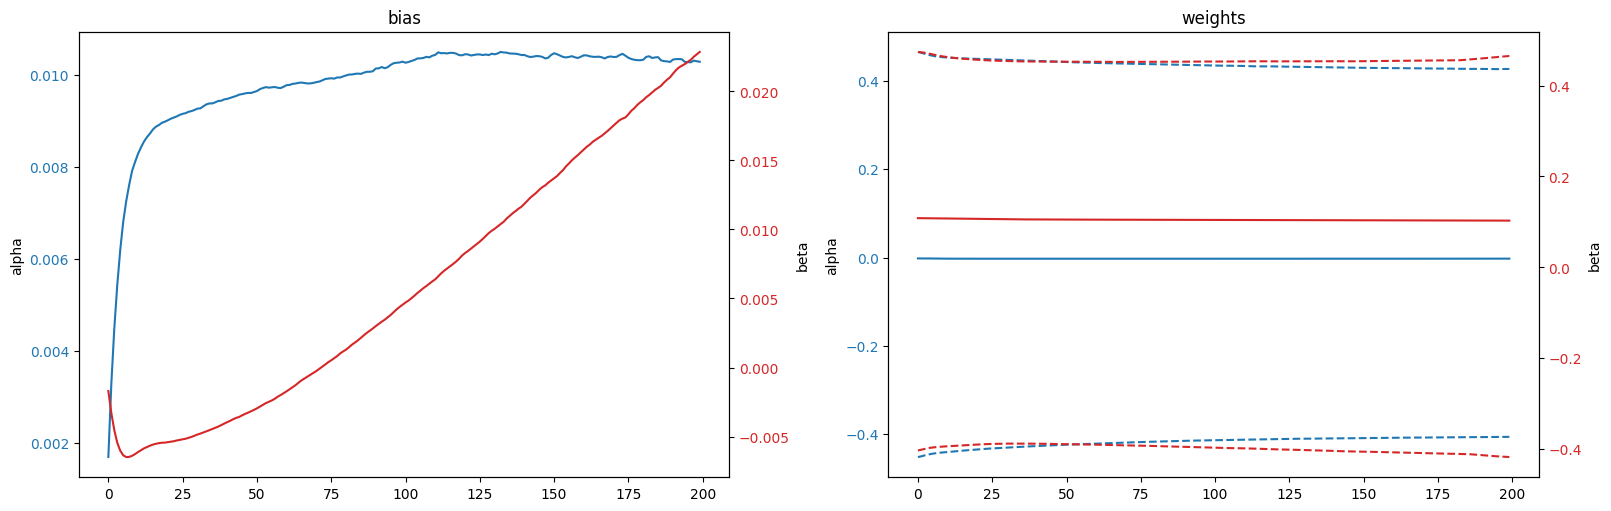

In [20]:
# Plot training weights
wtte.plot_weights()

638/638 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


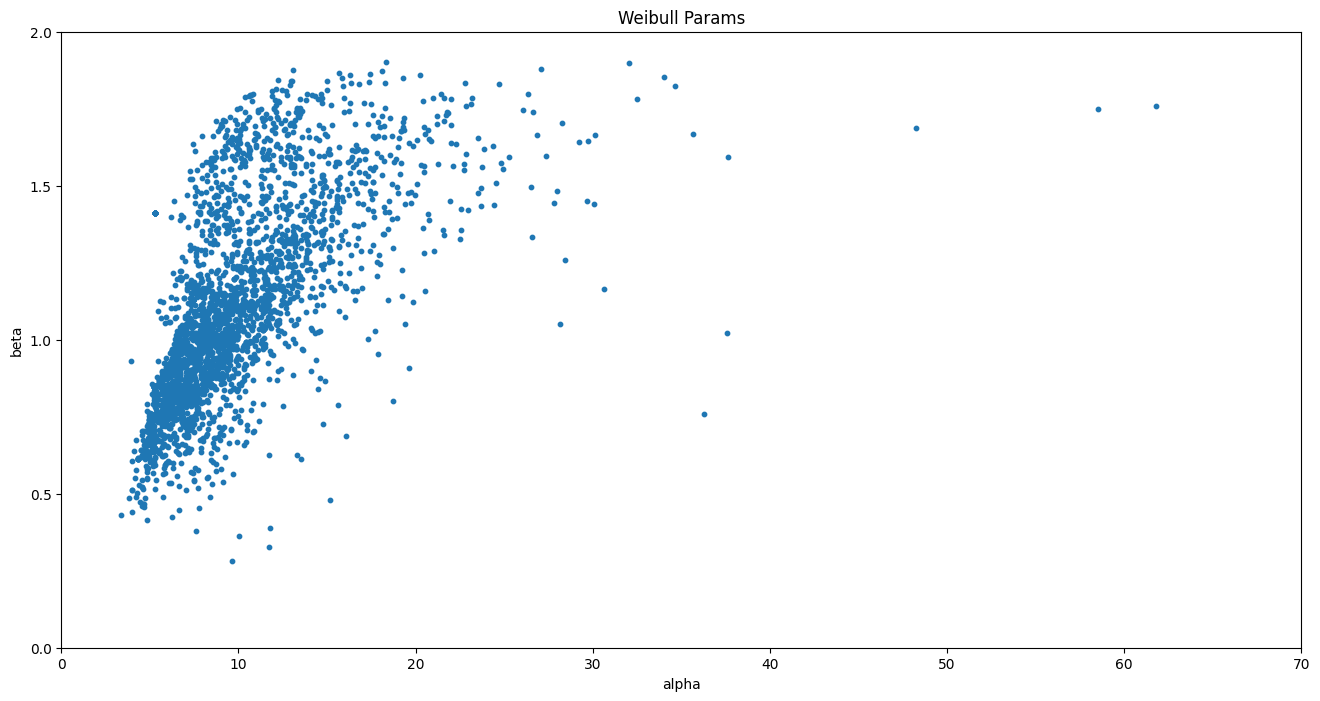

In [21]:
# Build deep validation tensor
# In this case, we need the complete (deep) sequences in order to analize the model performance
x_wtte_deep, y_wtte_deep = wtte.build_seq(d_wtte_test, deep=True)

# Get sequence lengths
wtte.sls = wtte.get_seq_lengths(y_wtte_deep)
# Predict
y_wtte_hat = wtte.predict(x_wtte_deep)
# Set results
wtte.set_results(y_wtte_hat, y_wtte_deep)

# Plot the distribution of Weibull alpha and beta parameters
wtte.plot_params_dist(wtte.results, loc=-1)

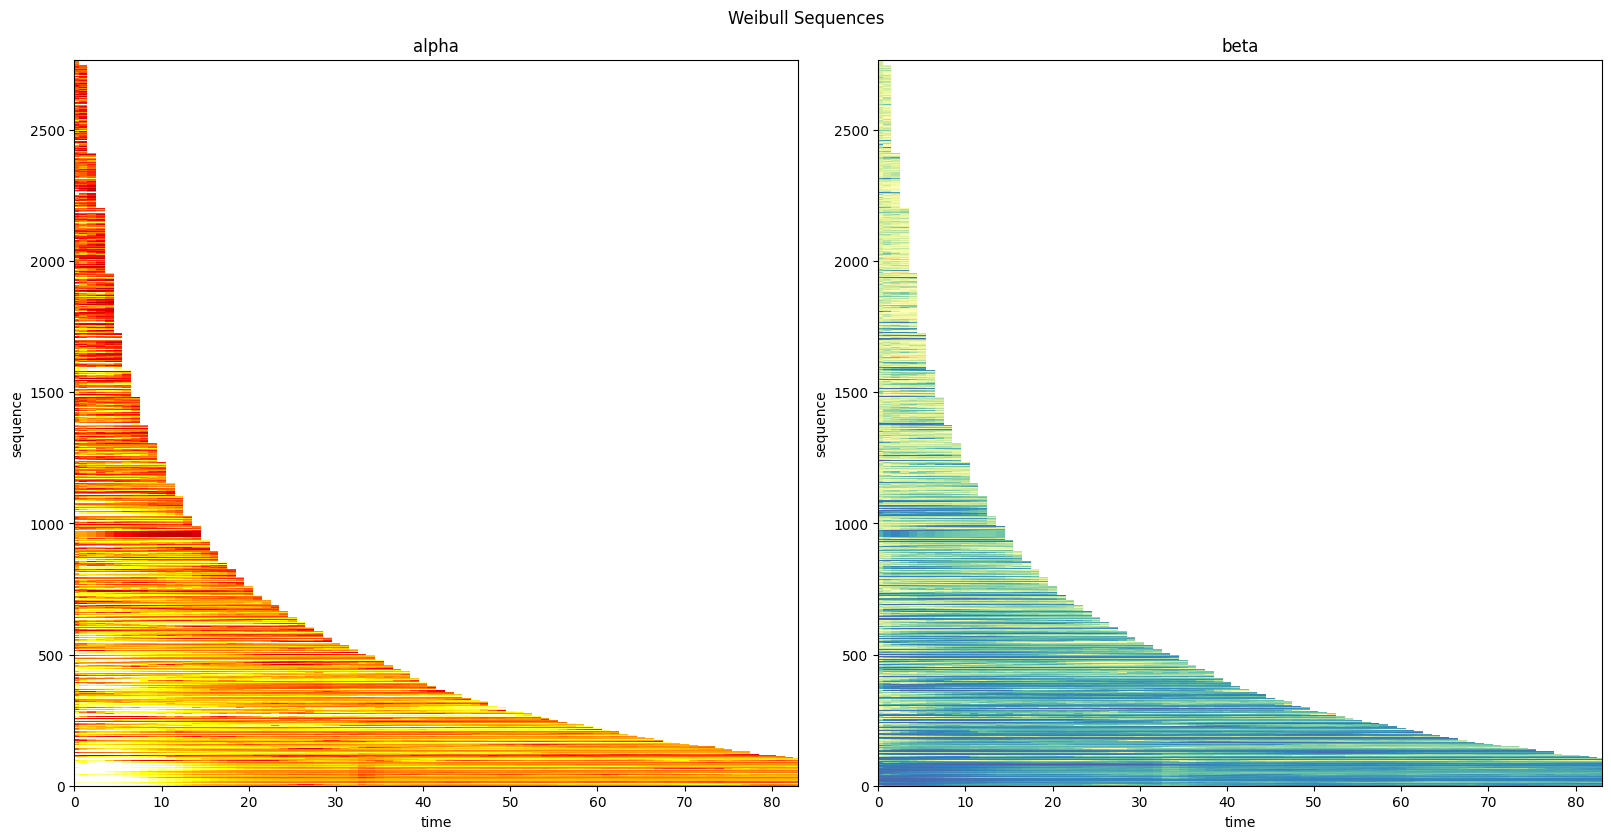

In [22]:
# Plot each customer Weibull alpha and beta parameters over time
wtte.plot_params_seq(wtte.results)

In [23]:
# Prediction results
wtte.results

,id,tfs,wa,wb,pred,true
0,9,4,21.135954,1.633956,0.021001,0
1,9,5,23.630066,1.565543,0.020726,0
2,9,6,26.597744,1.622124,0.014920,0
3,9,7,23.652664,1.571558,0.020393,1
4,9,8,19.967520,1.469453,0.033436,1
...,...,...,...,...,...,...
50570,11062,0,9.139981,0.925836,0.217234,0
50571,11063,0,6.812823,1.048432,0.241676,0
50572,11064,0,6.866727,0.984414,0.256892,0
50573,11065,0,7.384730,1.038401,0.227079,0


In [24]:
# Select random customers from the results
n_samples = 6  # Number of customers
min_periods = 6  # Minimum number of periods recorded

ids = shuffle(
    wtte.results['id'].tolist()
)[:n_samples]

print(ids)

[2059, 7479, 443, 7730, 9974, 472]


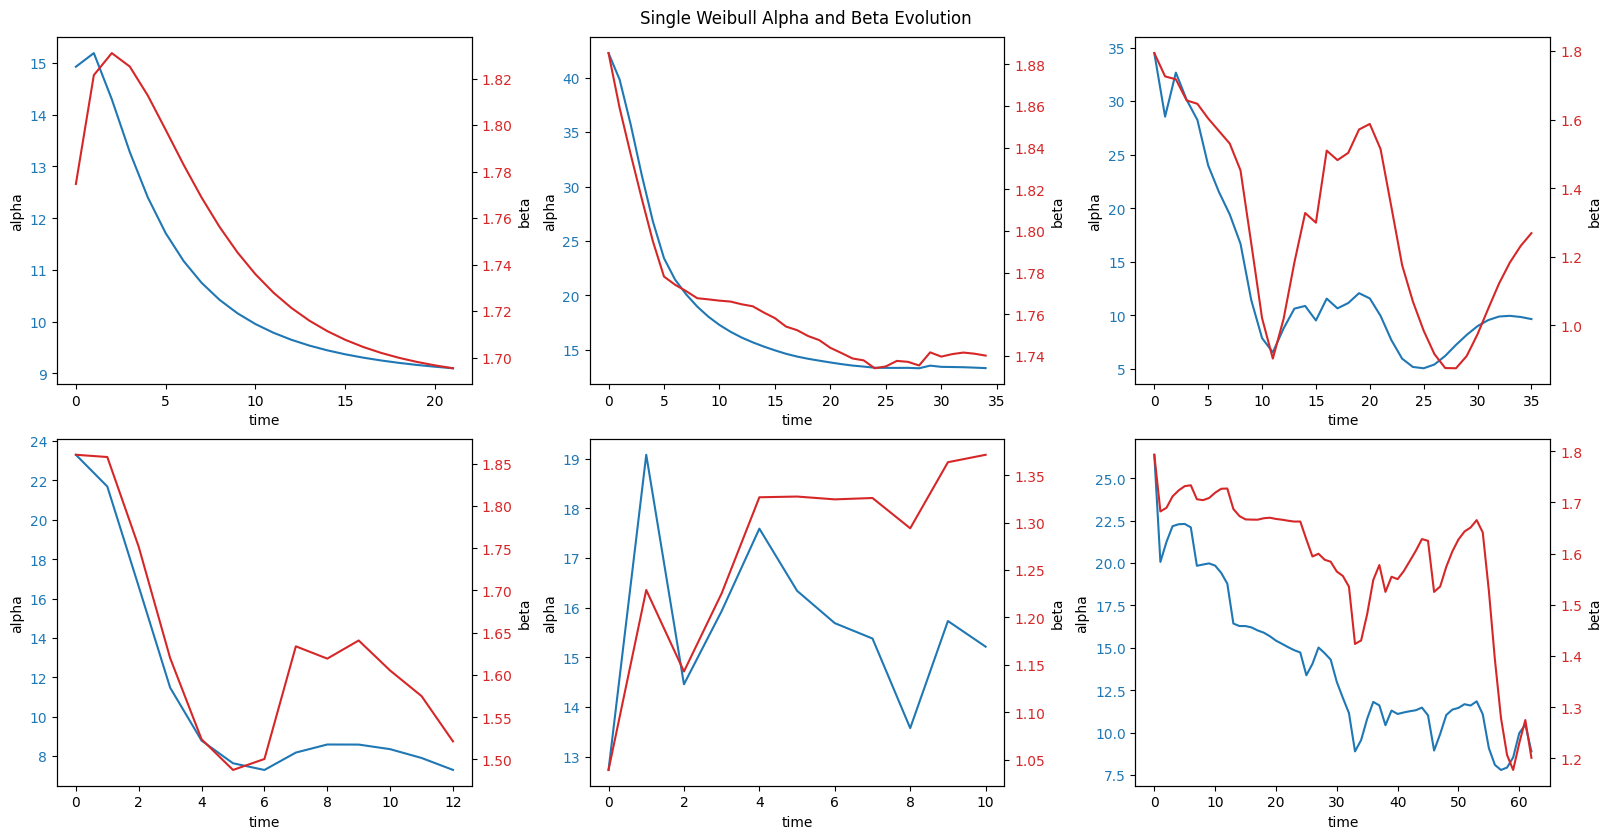

In [25]:
"""
Plot the distribution of the Weibull alpha and beta parameters
for a single customer over time, showing how the parameters change
from one period to the next as the customer info and usage change.

The alpha parameter represents the scale of the Weibull distribution,
which denotes the time it takes for the customer to churn,
while the beta parameter represents the shape of the Weibull distribution,
which is a measure of dispersion, meaning how sure we are about the result.
"""

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), constrained_layout=True)
axs = axs.flatten()

for i, uid in enumerate(ids):
    wtte.plot_single_params(wtte.results, id=uid, ax=axs[i])

plt.suptitle('Single Weibull Alpha and Beta Evolution', y=1.03)

plt.show()

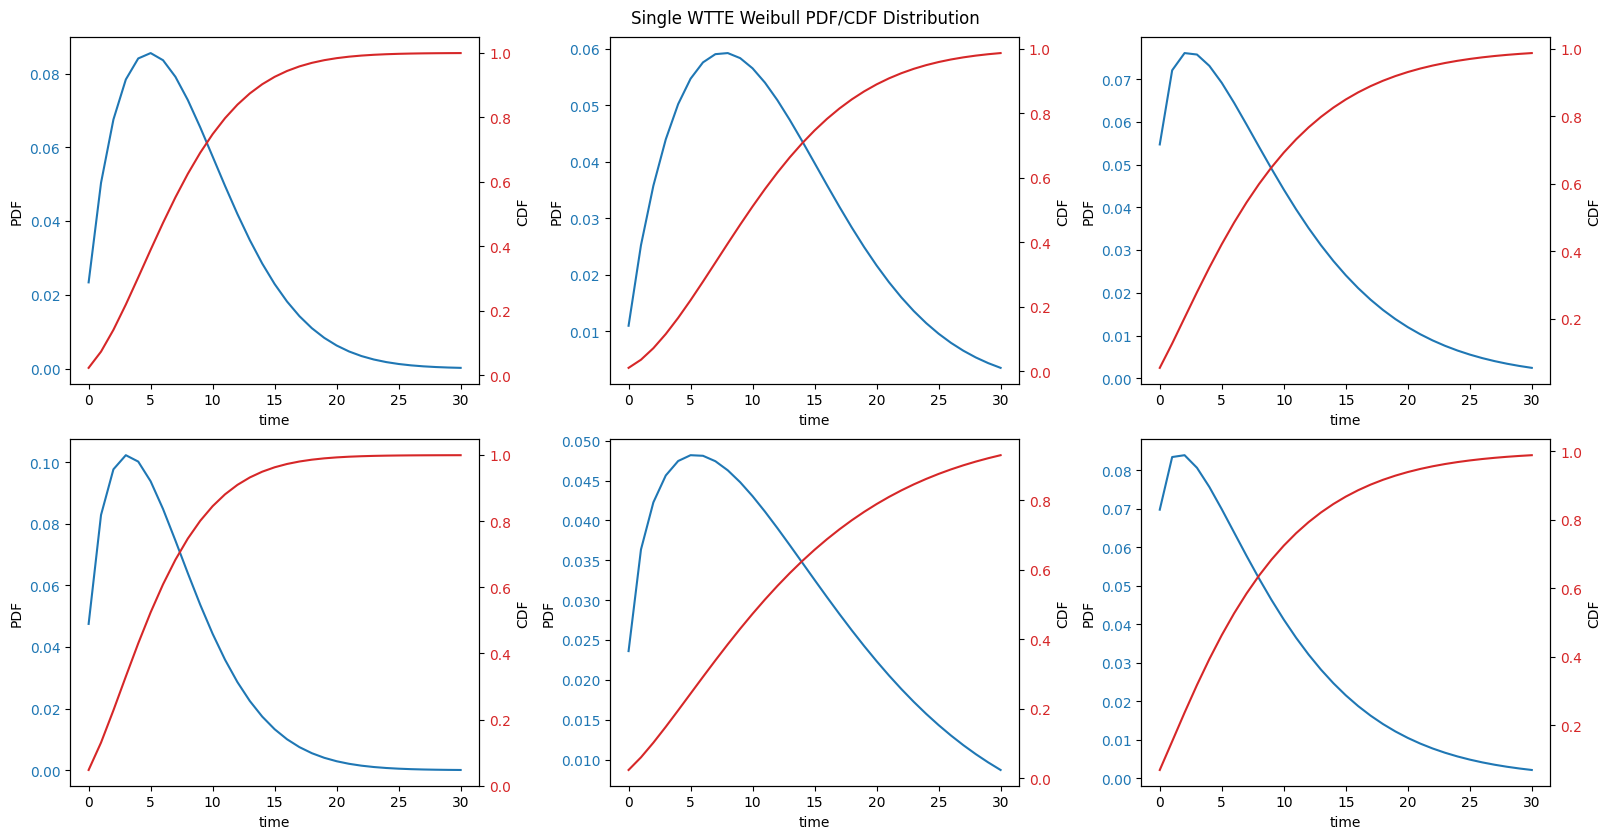

In [26]:
"""
Plot both the probability and cumulative functions for a single customer at a specific period,
showing how the survival of the customer is modeled by the Weibull distribution.

Basically, the probability function shows the probability of the customer
to churn at a given time (the peak of the distribution is the most probable churn period),
while the cumulative function shows the probability of the customer to churn before any given time.
"""

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), constrained_layout=True)
axs = axs.flatten()

for i, uid in enumerate(ids):
    wtte.plot_weibull(wtte.results, id=uid, loc=-1, ax=axs[i])

plt.suptitle('Single WTTE Weibull PDF/CDF Distribution', y=1.03)

plt.show()

In [27]:
# Get the last sequence prediction for each customer
results = (
    wtte.results
    .sort_values(['id', 'tfs'])
    .groupby('id')
    .last()
    .drop(columns=['tfs'])
    .reset_index()
)

show_summary(results, 'true')
results

Shape: 2,768 x 5
    1: 2,098 (75.79%)
    0: 670 (24.21%)


,id,wa,wb,pred,true
0,9,19.967520,1.469453,0.033436,1
1,10,9.993677,1.027775,0.174182,1
2,13,21.836967,1.736299,0.015632,1
3,15,10.813103,1.144647,0.134890,1
4,20,9.231973,1.592964,0.083752,1
...,...,...,...,...,...
2763,11062,9.139981,0.925836,0.217234,0
2764,11063,6.812823,1.048432,0.241676,0
2765,11064,6.866727,0.984414,0.256892,0
2766,11065,7.384730,1.038401,0.227079,0


In [28]:
# Instantiate Ensemble model in order to compute and plot the scores
model = ChurnEnsemble(
    seed=SEED,
    verbose=0,
    path='../files'
).set_data(data)
# Set the WTTE model
model.wtte = wtte

model

In [29]:
# Set model results from WTTE predictions
model.set_results(wtte.results)
# Compute and set model scores
model.set_scores(wtte.results)

model.results

,id,tfs,wa,wb,pred,true,tgt,segment,wa,wb,momentum,cid
0,9,4,21.135954,1.633956,0.021001,0,0,1,21.135954,1.633956,0.00,51f5447aa4dcd3245d000036
1,9,5,23.630066,1.565543,0.020726,0,0,1,23.630066,1.565543,0.38,51f5447aa4dcd3245d000036
2,9,6,26.597744,1.622124,0.014920,0,0,1,26.597744,1.622124,0.32,51f5447aa4dcd3245d000036
3,9,7,23.652664,1.571558,0.020393,1,0,1,23.652664,1.571558,-0.70,51f5447aa4dcd3245d000036
4,9,8,19.967520,1.469453,0.033436,1,0,1,19.967520,1.469453,-6.75,51f5447aa4dcd3245d000036
...,...,...,...,...,...,...,...,...,...,...,...,...
50570,11062,0,9.139981,0.925836,0.217234,0,0,2,9.139981,0.925836,0.00,6661e576a98733f247acc46c
50571,11063,0,6.812823,1.048432,0.241676,0,0,3,6.812823,1.048432,0.00,6661e7dfa98733f247acc5cd
50572,11064,0,6.866727,0.984414,0.256892,0,0,3,6.866727,0.984414,0.00,666227321e0bd65a73be6c31
50573,11065,0,7.384730,1.038401,0.227079,0,0,3,7.384730,1.038401,0.00,66633bcee489710bb6afe3d9


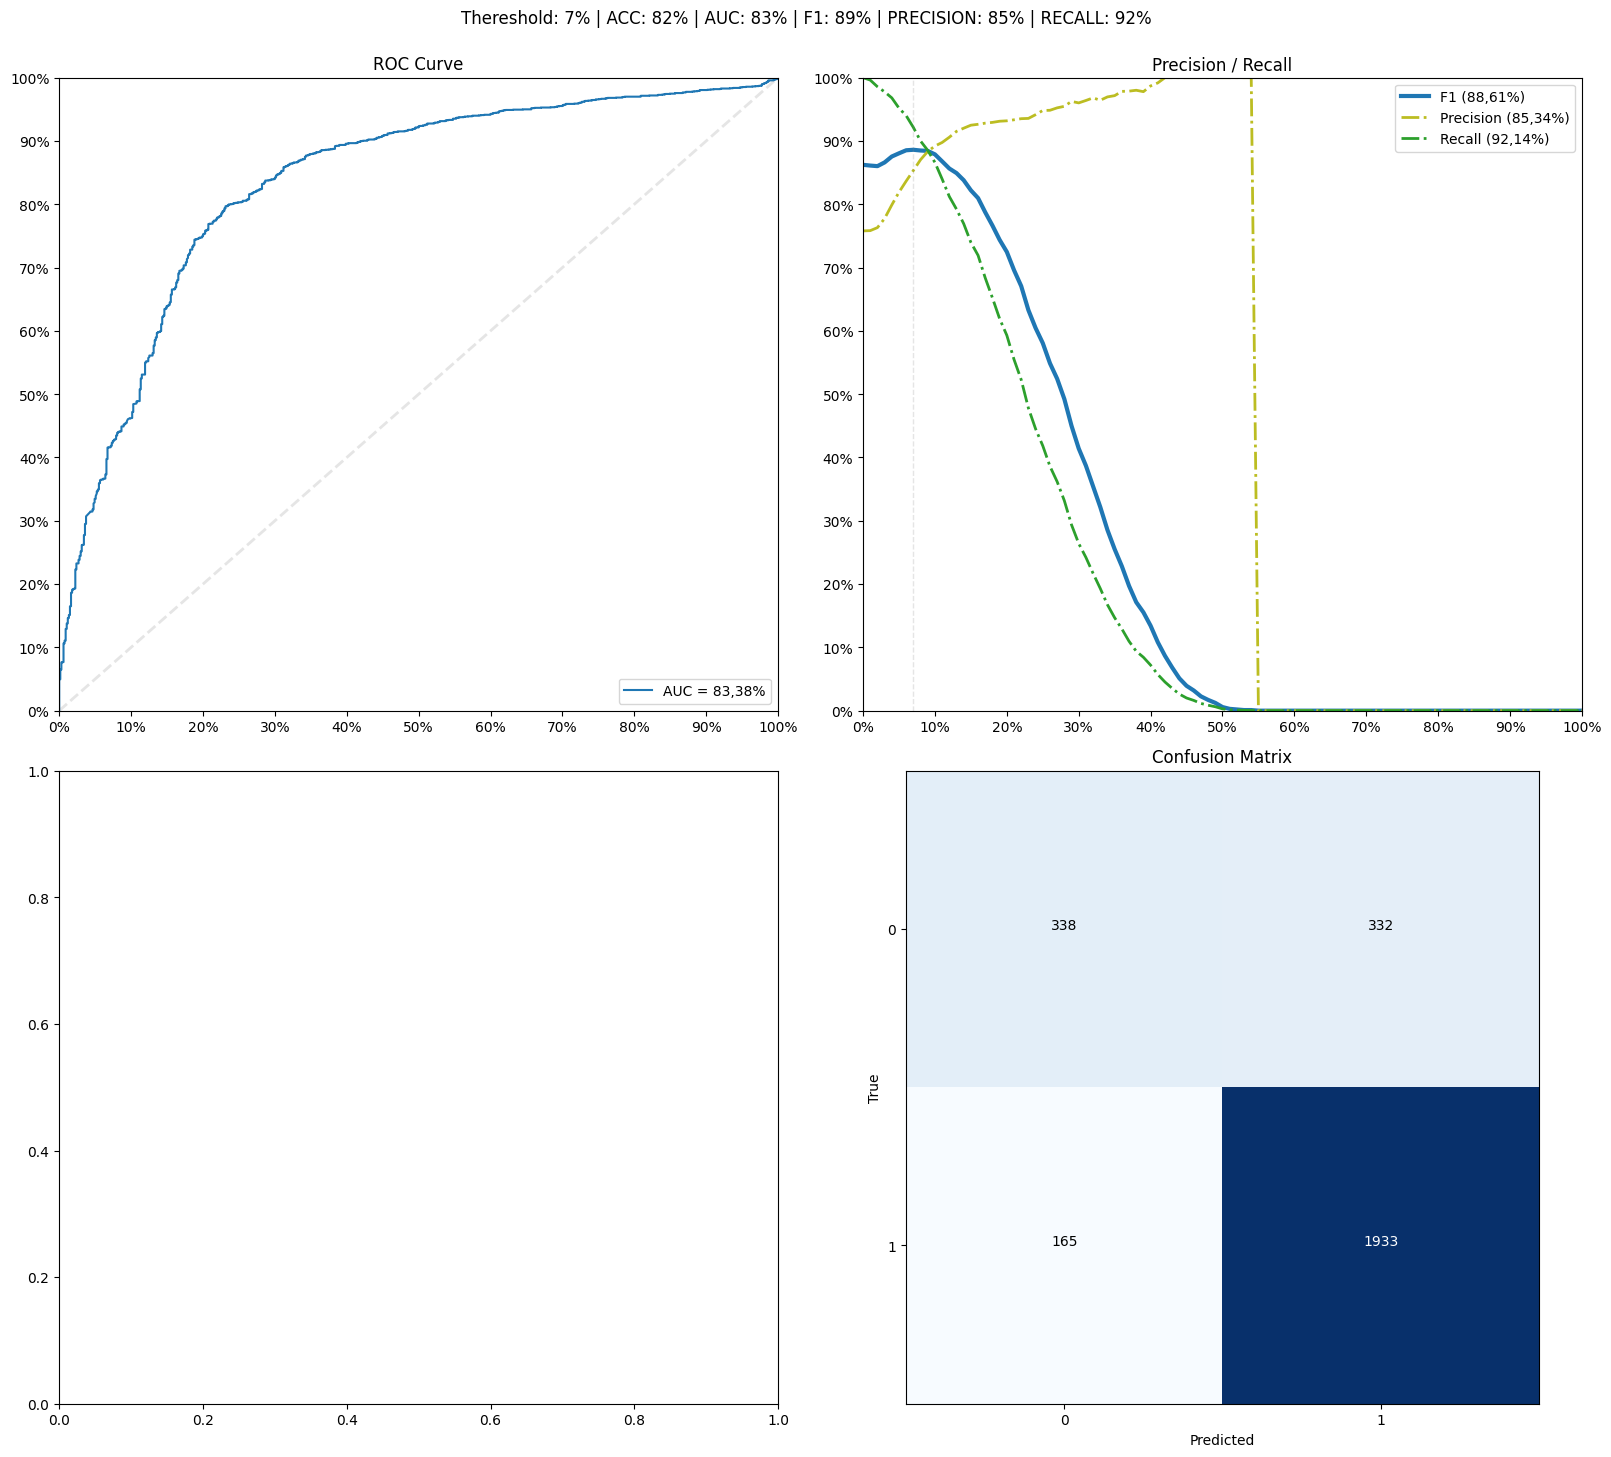

In [30]:
# Plot scores summary
model.plot_scores(wtte.results)

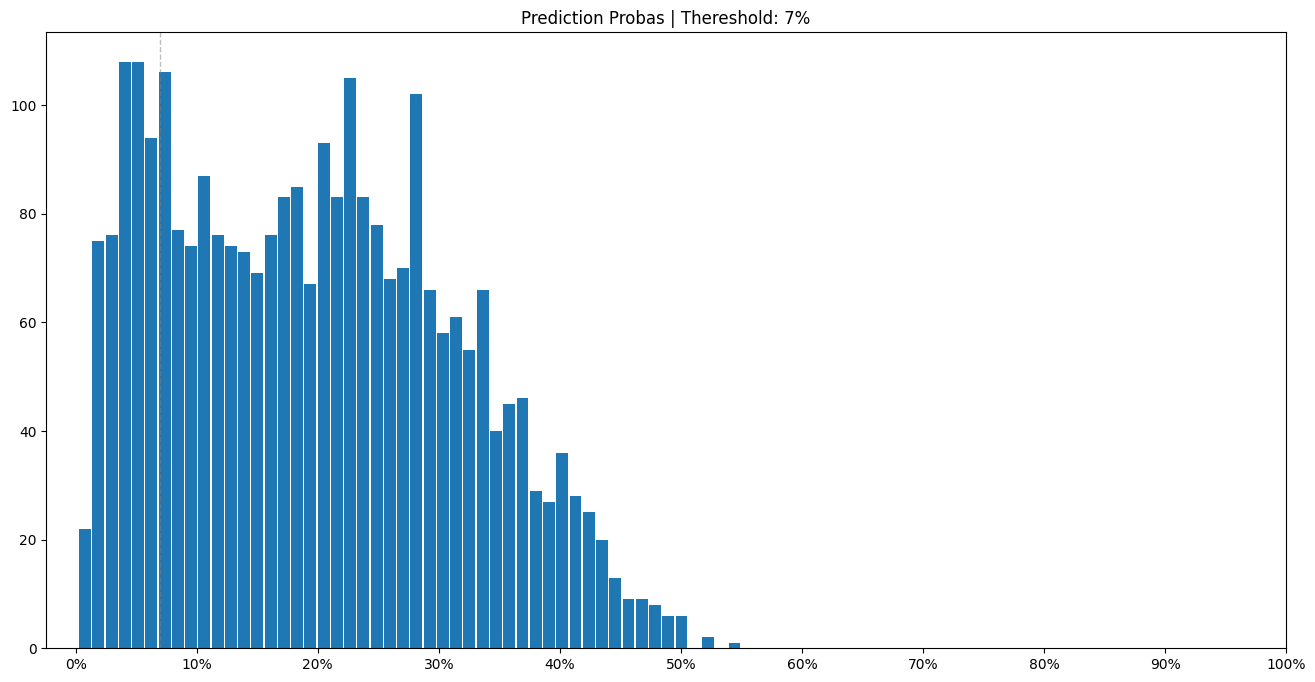

In [31]:
# Plot histogram of predicted probabilities for each customer sequence
model.plot_histogram(wtte.results)